In [1]:
from sentinelsat import SentinelAPI, make_path_filter # for downloading data
import geopandas as gpd # for reading shapefiles
import folium  # library to create interactive maps
from shapely.geometry import MultiPolygon, Polygon
import os 
import rasterio as rio
from rasterio.mask import mask
import zipfile
import rasterio
import json
import shutil
from skimage.metrics import structural_similarity
import cv2
import numpy as np
# read credentials.json
with open('credentials.json') as f:
    credentials = json.load(f)

user = credentials['SENTINEL_USER']
password = credentials['SENTINEL_PASSWORD']
api = SentinelAPI(user, password, 'https://scihub.copernicus.eu/dhus')
import matplotlib.pyplot as plt
%matplotlib inline

ModuleNotFoundError: No module named 'skimage'

In [ ]:
!pip install scikit-image

     |████████████████████████████████| 29.8 MB 7.0 kB/s            
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 3.3 MB 54 kB/s             
     |████████████████████████████████| 148 kB 49 kB/s             
     |████████████████████████████████| 4.3 MB 83 kB/s             
     |████████████████████████████████| 3.0 MB 190 kB/s            

In [ ]:
nyc_geo = gpd.read_file('data/layers/POLYGON.shp')

In [3]:
m = folium.Map([40.730610, -73.935242], zoom_start=10) # New York City

folium.GeoJson(nyc_geo).add_to(m)
# visualize the map
m

In [4]:
footprint = None
for i in nyc_geo['geometry']:
    footprint = i

In [5]:
products = api.query(footprint,
                     date = ('20200101', '20220905'),
                     platformname = 'Sentinel-2',
                     processinglevel = 'Level-2A',
                     cloudcoverpercentage = (0,10)
                    )

In [6]:
products_gdf = api.to_geodataframe(products)
products_gdf_sorted = products_gdf.sort_values(['cloudcoverpercentage'], ascending=[True])
products_gdf_sorted.shape

(82, 41)

In [7]:
products_gdf['is_online'] = [api.is_online(product_id) for product_id in products_gdf.index]

In [8]:
products_gdf = products_gdf[products_gdf['is_online']]

In [9]:
products_gdf.sort_values('orbitnumber',ascending=True,inplace=True)

In [11]:
earliest_artifact = api.download(products_gdf.index[0])


In [12]:
latest_artifact = api.download(products_gdf.index[-1])

In [13]:
latest_artifact

{'id': 'e651bc7e-4f32-4941-90fa-31c1e0a2a6f5',
 'title': 'S2B_MSIL2A_20200505T154809_N0214_R054_T18TWL_20200505T194233',
 'size': 1166518402,
 'md5': '879aeabf29c619b22676e2af9b79af82',
 'date': datetime.datetime(2020, 5, 5, 15, 48, 9, 24000),
 'footprint': 'POLYGON((-73.6976 40.847361177759886,-73.70273 40.83326386215816,-73.75577 40.68714102473281,-73.8031 40.556032733316954,-75.000244 40.56274991351036,-75.000244 41.551844670066835,-73.68381 41.54431153543986,-73.6976 40.847361177759886))',
 'url': "https://scihub.copernicus.eu/dhus/odata/v1/Products('e651bc7e-4f32-4941-90fa-31c1e0a2a6f5')/$value",
 'Online': True,
 'Creation Date': datetime.datetime(2020, 5, 6, 2, 59, 14, 837000),
 'Ingestion Date': datetime.datetime(2020, 5, 6, 2, 56, 50, 36000),
 'quicklook_url': "https://scihub.copernicus.eu/dhus/odata/v1/Products('e651bc7e-4f32-4941-90fa-31c1e0a2a6f5')/Products('Quicklook')/$value",
 'path': 'S2B_MSIL2A_20200505T154809_N0214_R054_T18TWL_20200505T194233.zip',
 'downloaded_bytes'

In [14]:
try:
    with zipfile.ZipFile(latest_artifact['path']) as z:
        z.extractall()
        print("Extracted all")
        os.remove(latest_artifact['path'])
except:
    print("Invalid file")

try:
    with zipfile.ZipFile(earliest_artifact['path']) as z:
        z.extractall()
        print("Extracted all")
        os.remove(earliest_artifact['path'])
except:
    print("Invalid file")    

Extracted all


In [19]:
earliest_img_dir = earliest_artifact['path'].replace('.zip','.SAFE')
latest_img_dir = latest_artifact['path'].replace('.zip','.SAFE')

In [26]:
def get_bands(imagery_folders):

    l2a_folder = os.listdir(f'{imagery_folders}/GRANULE')[0]
    r10_path = f"{imagery_folders}/GRANULE/{l2a_folder}/IMG_DATA/R10m"
    for band in os.listdir(r10_path):
        # extract bands 2,3, and 4 from r10:
        if 'B02' in band:
            b2 = rio.open(f"{r10_path}/{band}")
        elif 'B03' in band:
            b3 = rio.open(f"{r10_path}/{band}")
        elif 'B04' in band:
            b4 = rio.open(f"{r10_path}/{band}")

    return b2, b3, b4

In [30]:
b2, b3, b4 = get_bands(earliest_img_dir)


with rio.open('RGB.tiff','w',driver='Gtiff', width=b4.width, height=b4.height, 
        count=3,crs=b4.crs,transform=b4.transform, dtype=b4.dtypes[0]) as rgb:
        rgb.write(b2.read(1),1) 
        rgb.write(b3.read(1),2) 
        rgb.write(b4.read(1),3) 
        rgb.close()

with rio.open("RGB.tiff") as src:
        out_meta = src.meta.copy()
        nyc_geo_projected = nyc_geo.to_crs(out_meta['crs'].data)
        out_image, out_transform = mask(src, nyc_geo_projected.geometry,crop=True) #TODO: note that projected has to be in the geo from out_meta. 
        out_meta = src.meta.copy()
        out_meta.update({"driver": "GTiff",
                        "height": out_image.shape[1],
                        "width": out_image.shape[2],
                        "transform": out_transform})

with rasterio.open(f"{earliest_artifact['title']}.tiff", "w", **out_meta) as dest:
        dest.write(out_image)


os.remove("RGB.tiff")
shutil.rmtree(earliest_img_dir)


b2, b3, b4 = get_bands(latest_img_dir)


with rio.open('RGB.tiff','w',driver='Gtiff', width=b4.width, height=b4.height, 
        count=3,crs=b4.crs,transform=b4.transform, dtype=b4.dtypes[0]) as rgb:
        rgb.write(b2.read(1),1) 
        rgb.write(b3.read(1),2) 
        rgb.write(b4.read(1),3) 
        rgb.close()

with rio.open("RGB.tiff") as src:
        out_meta = src.meta.copy()
        nyc_geo_projected = nyc_geo.to_crs(out_meta['crs'].data)
        out_image, out_transform = mask(src, nyc_geo_projected.geometry,crop=True) #TODO: note that projected has to be in the geo from out_meta. 
        out_meta = src.meta.copy()
        out_meta.update({"driver": "GTiff",
                        "height": out_image.shape[1],
                        "width": out_image.shape[2],
                        "transform": out_transform})

with rasterio.open(f"{latest_artifact['title']}.tiff", "w", **out_meta) as dest:
        dest.write(out_image)


os.remove("RGB.tiff")
shutil.rmtree(latest_img_dir)


/Users/noahkasmanoff/anaconda3/envs/nasaeo/lib/python3.9/site-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [43]:
earliest_raster = rio.open('S2B_MSIL2A_20200505T154809_N0214_R054_T18TWL_20200505T194233.tiff').read()
latest_raster = rio.open('S2A_MSIL2A_20220825T155151_N0400_R011_T18TWL_20220825T220800.tiff').read()

In [52]:
earliest_raster_mean = earliest_raster.mean(axis=0)
latest_raster_mean = latest_raster.mean(axis=0)

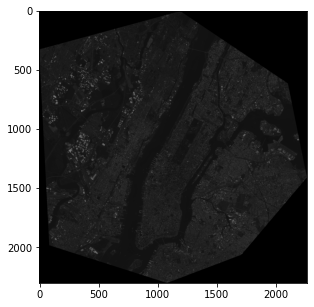

In [56]:
plt.figure(figsize=(5,5))
plt.imshow(latest_raster_mean,cmap='gray')

In [59]:
(score, diff) = structural_similarity(earliest_raster_mean, latest_raster_mean, full=True)

In [60]:
score

0.5749724556794453

In [117]:
(score, diff) = structural_similarity(earliest_raster_mean, latest_raster_mean, full=True)
#diff[diff < .99] = 1

diff = (diff * 255).astype("uint8")
diff_box = cv2.merge([diff, diff, diff])

# Threshold the difference image, followed by finding contours to
# obtain the regions of the two input images that differ
thresh = cv2.threshold(diff, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = contours[0] if len(contours) == 2 else contours[1]

mask = np.zeros(earliest_raster_mean.shape, dtype='uint8')
saved_countours = []
for c in contours:
    area = cv2.contourArea(c)
    if 500 < area < 15000:
        cv2.drawContours(mask, [c], 0, (255,255,255), -1)
        saved_countours.append(c)


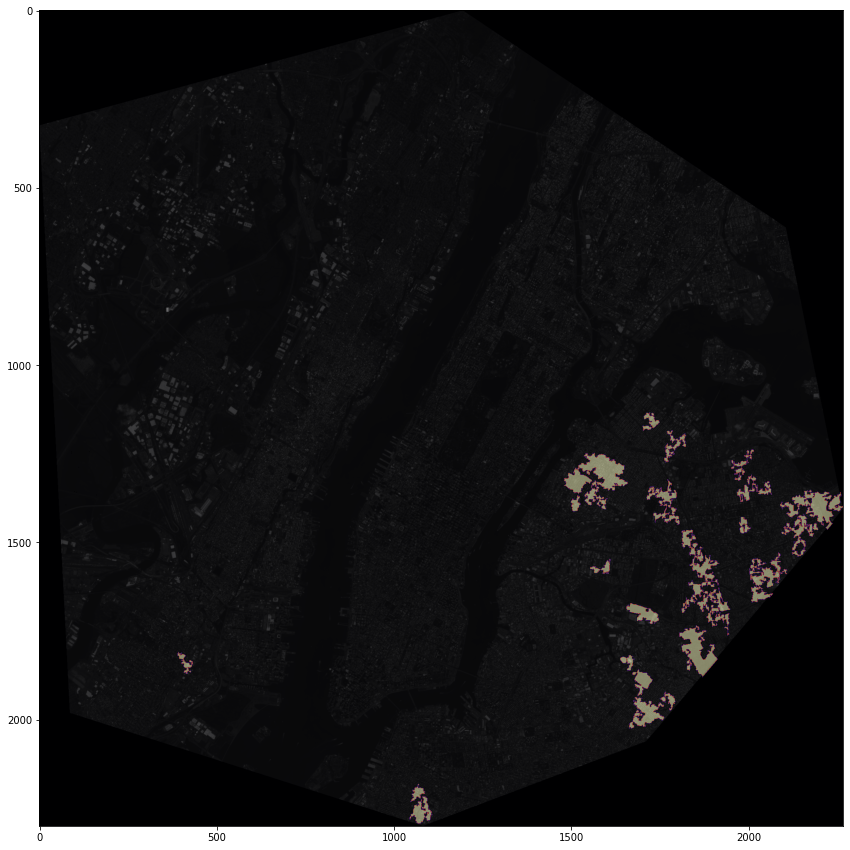

In [118]:
plt.figure(figsize=(15,15))
plt.imshow(latest_raster_mean,cmap='gray')
plt.imshow(mask,cmap='magma',alpha=.5)


In [123]:
# split this into sub-images. 
import cv2
import math

tile = 64
img_height = latest_raster.shape[1]
img_width = latest_raster.shape[2]

num_vertical_tiles = img_height // tile
num_horizontal_tiles = img_width // tile
cropped_img = latest_raster[:,:tile*num_vertical_tiles, :tile*num_horizontal_tiles]


In [158]:
# for loop split

tiled_image = []
for i in range(0, img_height, tile):
    for j in range(0, img_width, tile):
        tiled_image.append(cropped_img[:,i:i+tile,j:j+tile])

        # psuedo segmen? 
# convert to tensor, predict
        

In [175]:

tiled_array = np.zeros((cropped_img.shape[1],cropped_img.shape[2]))
tiled_images = []
# loop through segments of image
for i in range(0, img_height, tile):
    for j in range(0, img_width, tile):
        tiled_image = cropped_img[:,i:i+tile,j:j+tile]
        # some are shape 0??
        tiled_images.append(tiled_image)
        tiled_array[i:i+tile,j:j+tile] = i*j # replace i * j with prediction

(3, 64, 64)
(3, 64, 64)
(3, 64, 64)
(3, 64, 64)
(3, 64, 64)
(3, 64, 64)
(3, 64, 64)
(3, 64, 64)
(3, 64, 64)
(3, 64, 64)
(3, 64, 64)
(3, 64, 64)
(3, 64, 64)
(3, 64, 64)
(3, 64, 64)
(3, 64, 64)
(3, 64, 64)
(3, 64, 64)
(3, 64, 64)
(3, 64, 64)
(3, 64, 64)
(3, 64, 64)
(3, 64, 64)
(3, 64, 64)
(3, 64, 64)
(3, 64, 64)
(3, 64, 64)
(3, 64, 64)
(3, 64, 64)
(3, 64, 64)
(3, 64, 64)
(3, 64, 64)
(3, 64, 64)
(3, 64, 64)
(3, 64, 64)
(3, 64, 0)
(3, 64, 64)
(3, 64, 64)
(3, 64, 64)
(3, 64, 64)
(3, 64, 64)
(3, 64, 64)
(3, 64, 64)
(3, 64, 64)
(3, 64, 64)
(3, 64, 64)
(3, 64, 64)
(3, 64, 64)
(3, 64, 64)
(3, 64, 64)
(3, 64, 64)
(3, 64, 64)
(3, 64, 64)
(3, 64, 64)
(3, 64, 64)
(3, 64, 64)
(3, 64, 64)
(3, 64, 64)
(3, 64, 64)
(3, 64, 64)
(3, 64, 64)
(3, 64, 64)
(3, 64, 64)
(3, 64, 64)
(3, 64, 64)
(3, 64, 64)
(3, 64, 64)
(3, 64, 64)
(3, 64, 64)
(3, 64, 64)
(3, 64, 64)
(3, 64, 0)
(3, 64, 64)
(3, 64, 64)
(3, 64, 64)
(3, 64, 64)
(3, 64, 64)
(3, 64, 64)
(3, 64, 64)
(3, 64, 64)
(3, 64, 64)
(3, 64, 64)
(3, 64, 64)
(3, 64

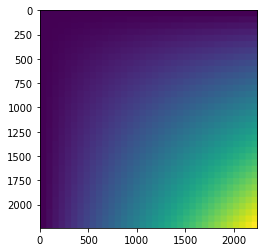

In [169]:
# repeate the above for both earliest and latest, and BOOM!

In [174]:
tiled_image

array([], shape=(3, 0, 64), dtype=uint16)